Meeting notes:
Story: how does community info encoded, when does it matter?

Do norms capture degree? or maybe if they're adding some centrality measure but is that reducing the performance? Where does the centrality info used in the random walks go? in the angles? LFR doesn't have correlation (no traiangles) Does norm capture degree? and angular info captures community? In correlated networks does it help to separate or combine both pieces of info?

Use core periphery structure networks an extreme example to test it out.


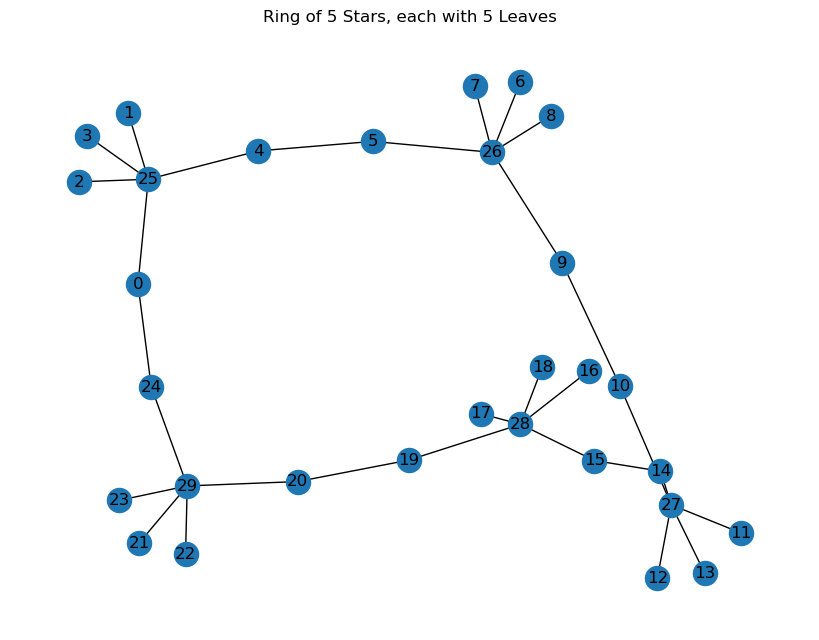

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [00:02<00:00, 100.95it/s, loss=1.26]
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/nobackup/gogandhi/miniconda3/envs/gensim_mod_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_a

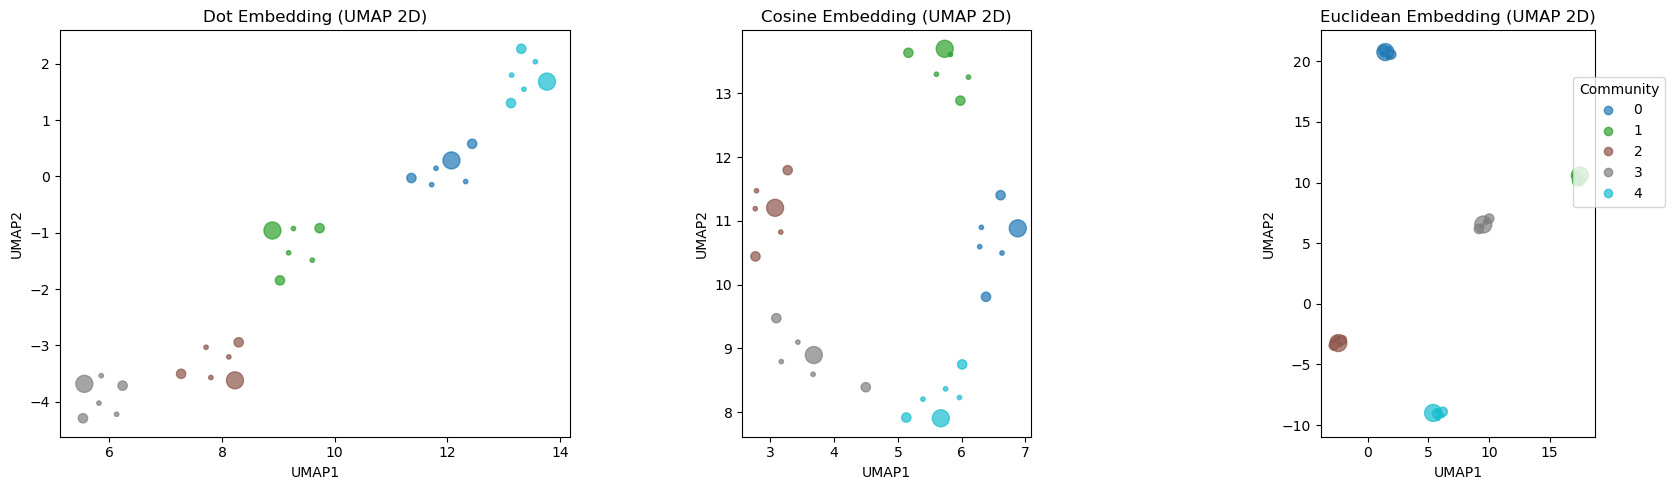

In [9]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score, normalized_mutual_info_score
from node2vecs import TorchNode2Vec

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.sparse as sp
import pandas as pd
import umap

import os
import random
import torch

# assuming calc_esim is already defined, and:
# embeddings: dict of name→(N×d) arrays,
# labels: length-N array in {0,1} for periphery and hubs assigned 0/1,
# n, H defined as before
def calc_esim(y, ypred):

    ylab, y = np.unique(y, return_inverse=True)
    ypredlab, ypred = np.unique(ypred, return_inverse=True)
    
    Ka, Kb = len(ylab), len(ypredlab)
    K = np.maximum(Ka, Kb)
    N = len(y)
    
    UA = sp.csr_matrix((np.ones_like(y), (np.arange(y.size), y)), shape=(N,K))
    UB = sp.csr_matrix((np.ones_like(ypred), (np.arange(ypred.size), ypred)), shape=(N, K))    
    
    nA = np.array(UA.sum(axis=0)).reshape(-1)
    nB = np.array(UB.sum(axis=0)).reshape(-1)

# nAB[i][j] is read as the number of elements that belong to ith ground truth label and jth predicrted label.
# nAB[1][0] = 1 For ground truth label with index 1 and predicted label 0 we have 1 element. i.e. 0000|1| vs 1110|0|

    nAB = (UA.T @ UB).toarray()
    nAB_rand = np.outer(nA, nB) / N
    
# assuming that each element has an equal probability of being assigned to any label,
# and the expected counts are calculated based on label frequencies.


    # Calc element-centric similarity
    Q = np.maximum(nA[:, None] @ np.ones((1, K)), np.ones((K, 1)) @ nB[None, :]) 
    Q = 1 / np.maximum(Q, 1)
    S = np.sum(np.multiply(Q, (nAB**2))) / N
    
    # Calc the expected element-centric similarity for random partitions
    #Q = np.maximum(nA[:, None] @ np.ones((1, K)), np.ones((K, 1)) @ nB[None, :]) 
    #Q = 1 / np.maximum(Q, 1)
    Srand = np.sum(np.multiply(Q, (nAB_rand**2))) / N
    Scorrected = (S - Srand) / (1 - Srand)
    return Scorrected





# # 1) Python built-ins
# random.seed(42)

# # 2) NumPy
# np.random.seed(42)

# # 3) PyTorch (affects Node2Vec's torch code)
# torch.manual_seed(42)
# torch.cuda.manual_seed_all(42)
# torch.use_deterministic_algorithms(True)            # make certain ops deterministic
# os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'   # if using CUDA

# # 4) scikit-learn / UMAP / other libs that take random_state
# UMAP_SEED     = 42
# KMEANS_SEED   = 42
# NODE2VEC_SEED = 42



# 1) Build a two-community core-periphery graph
def make_core_periphery_two_labels(
    n=100, H=4,
    p_in=0.1, p_out=0.005,
    p_hh=1, p_h_in=0.90, p_h_out=0.85
):
    G = nx.Graph()
    N = 2*n + H
    G.add_nodes_from(range(N))
    # peripheral communities
    for comm in (0,1):
        start = comm * n
        for u in range(start, start + n):
            for v in range(u+1, start + n):
                if np.random.rand() < p_in:
                    G.add_edge(u, v)
    # noise between communities
    for u in range(n):
        for v in range(n, 2*n):
            if np.random.rand() < p_out:
                G.add_edge(u, v)
    # hubs
    hubs = list(range(2*n, 2*n + H))
    # hub–hub core
    for i in range(H):
        for j in range(i+1, H):
            if np.random.rand() < p_hh:
                G.add_edge(hubs[i], hubs[j])
    # assign labels and hub biases
    labels = np.zeros(N, dtype=int)
    labels[n:2*n] = 1
    for idx, h in enumerate(hubs):
        home = idx % 2
        labels[h] = home
        # connect to home community
        for v in range(home*n, home*n + n):
            if np.random.rand() < p_h_in:
                G.add_edge(h, v)
        # connect to other community
        other = (1-home)*n
        for v in range(other, other + n):
            if np.random.rand() < p_h_out:
                G.add_edge(h, v)
    return G, labels

# Parameters


# n      = 200     # no of periphery nodes in each community
# H      = 50      # number of hubs in total network ( x/2 in each community)
# p_in   = 0.20    # fairly well‐connected periphery
# p_out  = 0.005   # almost no direct cross‐links
# p_hh   = 0.90    # hubs almost fully a clique
# p_h_in = 0.90    # strong bias into home community
# p_h_out= 0.70    # still lots of cross‐community hub edges
# vector_size = 32
# num_walks is self adjusted, and walk_length is default to 80

# n      = 200
# H      = 50
# p_in   = 0.15
# p_out  = 0.002
# p_hh   = 0.98
# p_h_in = 0.95
# p_h_out= 0.85
# vector_size = 32


# n      = 200
# H      = 50
# p_in   = 0.10
# p_out  = 0.0005
# p_hh   = 1.00
# p_h_in = 0.99
# p_h_out= 0.90
# vector_size = 32

n      = 200     # no of periphery nodes in each community
H      = 50      # number of hubs in total network ( x/2 in each community)
p_in   = 0.0    # fairly well‐connected periphery
p_out  = 0.0   # almost no direct cross‐links
p_hh   = 0.9   # hubs almost fully a clique
p_h_in = 1.0   # strong bias into home community
p_h_out= 0.5   # still lots of cross‐community hub edges
vector_size = 32

# 2) Generate graph and labels
#G, labels = make_core_periphery_two_labels(n, H, p_in, p_out, p_hh, p_h_in, p_h_out)
 
 
def ring_of_stars(leaves_per_hub: int, num_hubs: int):
    """
    – leaves_per_hub: number of peripheral nodes attached to each hub
    – num_hubs:       number of star‐centers (hubs)
    
    Returns:
      G, labels
      G:       networkx Graph of the ring-of-stars
      labels:  length-N array where each hub+its leaves share the same community id (0..num_hubs-1)
    """
    k = leaves_per_hub
    H = num_hubs
    total_leaves = k * H
    N = total_leaves + H   # total nodes = all leaves + all hubs

    G = nx.Graph()
    G.add_nodes_from(range(N))

    # Build each star and hook them up in a ring via their leaves
    for i in range(H):
        hub_id = total_leaves + i
        # leaf IDs for star i
        leaves = list(range(i*k, (i+1)*k))
        # connect hub to its leaves
        for leaf in leaves:
            G.add_edge(hub_id, leaf)
        # link this star to the next star via leaf→leaf
        next_first_leaf = ((i+1) % H) * k
        G.add_edge(leaves[-1], next_first_leaf)

    # Community labels: hub i and its leaves → label i
    labels = np.empty(N, dtype=int)
    for i in range(H):
        members = list(range(i*k, (i+1)*k)) + [total_leaves + i]
        labels[members] = i

    return G, labels

# 2) Generate graph and labels (rest of your pipeline stays exactly the same)
leaves_per_hub = 5   # ← how many per-hub leaves you want
H              = 5    # ← how many hubs
G, labels      = ring_of_stars(leaves_per_hub, H)



pos = nx.spring_layout(G)  # positions for all nodes
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True)
plt.title(f"Ring of {H} Stars, each with {leaves_per_hub} Leaves")
plt.axis('off')
plt.show()



# 3) Adjacency matrix
A = nx.to_scipy_sparse_array(G, format='csr')

# 4) Train embeddings
embeddings = {}
for metric in ['dot', 'cosine', 'euclidean']:
    model = TorchNode2Vec(
        vector_size=vector_size,
        similarity_metric=metric,
        device='cpu',
        num_workers=1
    )
    model.fit(A)
    embeddings[metric] = model.transform()

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.decomposition import PCA

deg_dict = dict(G.degree())
degrees  = np.array([deg_dict[i] for i in G.nodes()])

# Normalize for plotting (map min→20, max→200)
min_sz, max_sz = 10, 150
deg_norm = (degrees - degrees.min()) / (degrees.max() - degrees.min())
sizes    = min_sz + deg_norm * (max_sz - min_sz)

degrees.min(), degrees.max(), sizes.min(), sizes.max()

# 2) Embed plotting via 2D UMAP
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,   # tune between 5–50 for more local vs global structure
    min_dist=0.1,     # tune tighter clusters vs more spread
    random_state=42
    #n_jobs=6
)

from threadpoolctl import threadpool_limits


fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (metric, E) in zip(axes, embeddings.items()):
    # fit UMAP on this embedding
    
    with threadpool_limits(limits=1, user_api='blas'):
        Z = reducer.fit_transform(E)
        
    sc = ax.scatter(
        Z[:, 0], Z[:, 1],
        c=labels, cmap='tab10',
        s=sizes, alpha=0.7
    )
    ax.set_title(f"{metric.capitalize()} Embedding (UMAP 2D)")
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    ax.set_aspect('equal', 'box')

# shared legend

fig.legend(
    *sc.legend_elements(),
    title="Community",
    loc='upper right',
    bbox_to_anchor=(0.95, 0.85)
)

plt.tight_layout()
plt.show()
 

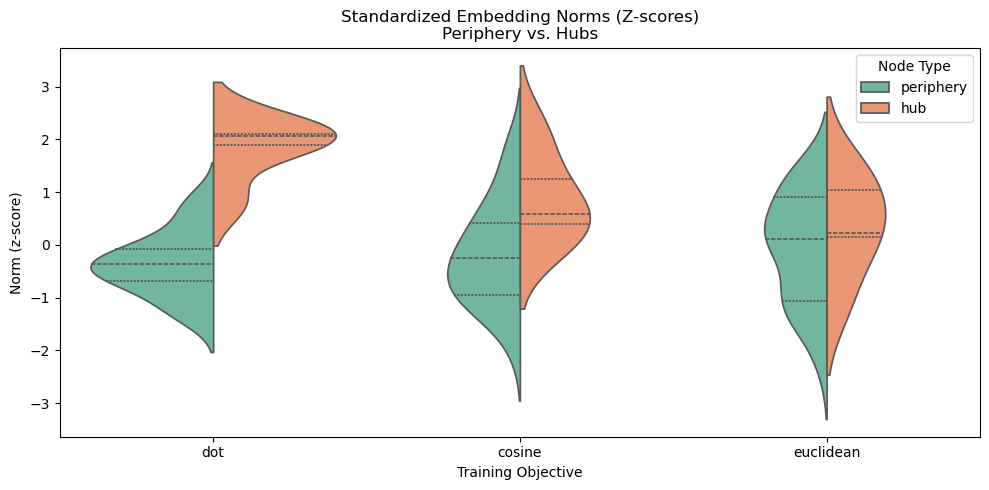

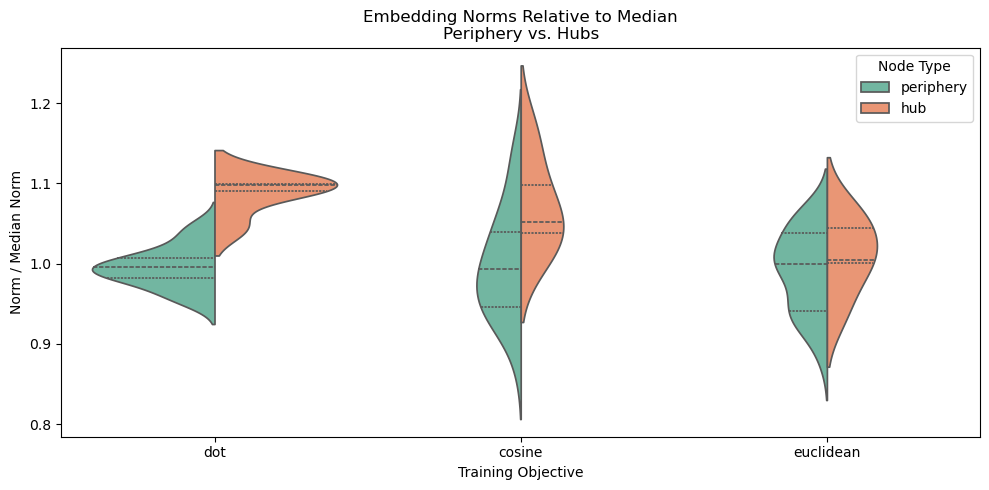

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Assumes embeddings, n, H are defined in the environment ---
# 1) Compute raw norms and standardized norms
data = []
total_leaves = leaves_per_hub * H   # ← compute how many leaves you really have
for metric, E in embeddings.items():
    norms      = np.linalg.norm(E, axis=1)
    mean_norm  = norms.mean()
    std_norm   = norms.std(ddof=0)
    median_norm= np.median(norms)
    
    for idx, norm in enumerate(norms):
        # classify by true periphery vs hubs
        node_type = 'periphery' if idx < total_leaves else 'hub'
        # standardized score (z-score)
        z     = (norm - mean_norm) / std_norm
        # ratio to median
        ratio = norm / median_norm
        data.append({
            'metric':      metric,
            'node_type':   node_type,
            'norm':        norm,
            'z_score':     z,
            'median_ratio':ratio
        })

df_norms = pd.DataFrame(data)


# 2) Plot distributions on uniform scale: z-scores
plt.figure(figsize=(10, 5))
sns.violinplot(
    x='metric', y='z_score', hue='node_type',
    data=df_norms, split=True, inner='quartile',
    palette='Set2'
)
plt.title('Standardized Embedding Norms (Z-scores)\nPeriphery vs. Hubs')
plt.xlabel('Training Objective')
plt.ylabel('Norm (z-score)')
plt.legend(title='Node Type')
plt.tight_layout()
plt.show()

# 3) Plot distributions of ratios to median norm
plt.figure(figsize=(10, 5))
sns.violinplot(
    x='metric', y='median_ratio', hue='node_type',
    data=df_norms, split=True, inner='quartile',
    palette='Set2'
)
plt.title('Embedding Norms Relative to Median\nPeriphery vs. Hubs')
plt.xlabel('Training Objective')
plt.ylabel('Norm / Median Norm')
plt.legend(title='Node Type')
plt.tight_layout()
plt.show()

In [11]:
from scipy.stats import ttest_ind, mannwhitneyu

total_leaves = leaves_per_hub * H

for metric, E in embeddings.items():
    norms    = np.linalg.norm(E, axis=1)
    per_norm = norms[:total_leaves]
    hub_norm = norms[total_leaves:]
    
    # parametric
    t_stat, p_t = ttest_ind(hub_norm, per_norm, equal_var=False)
    # non-parametric
    u_stat, p_u = mannwhitneyu(hub_norm, per_norm, alternative='two-sided')
    
    print(f"{metric:9s}  t-test p={p_t:.2e}   MWU p={p_u:.2e}")

def cohens_d(x,y):
    nx, ny = len(x), len(y)
    vx, vy = x.var(ddof=1), y.var(ddof=1)
    pooled = np.sqrt(((nx-1)*vx + (ny-1)*vy) / (nx+ny-2))
    return (x.mean() - y.mean()) / pooled

for metric, E in embeddings.items():
    norms    = np.linalg.norm(E, axis=1)
    per_norm = norms[:total_leaves]
    hub_norm = norms[total_leaves:]
    d = cohens_d(hub_norm, per_norm)
    print(f"{metric:9s}  Cohen’s d = {d:.2f}")



dot        t-test p=2.73e-04   MWU p=2.81e-05
cosine     t-test p=4.57e-02   MWU p=2.66e-02
euclidean  t-test p=4.14e-01   MWU p=3.00e-01
dot        Cohen’s d = 3.65
cosine     Cohen’s d = 1.11
euclidean  Cohen’s d = 0.41


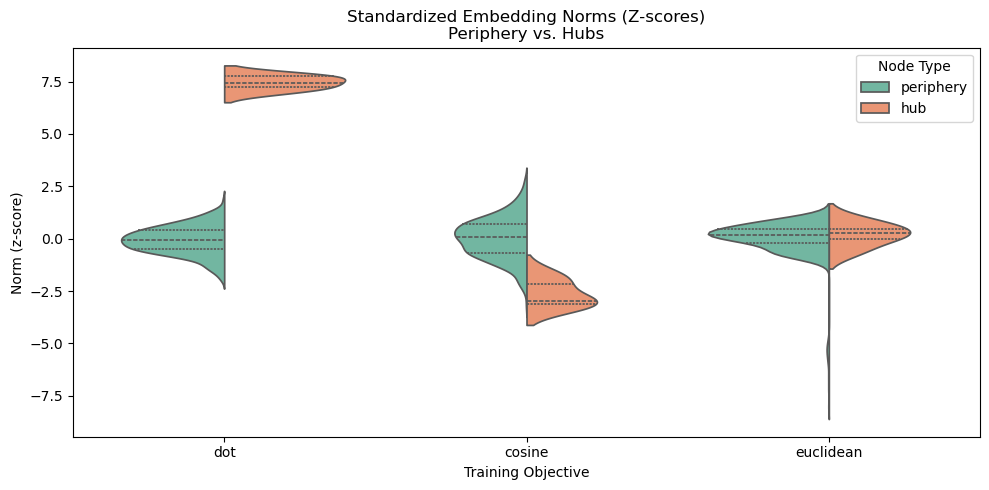

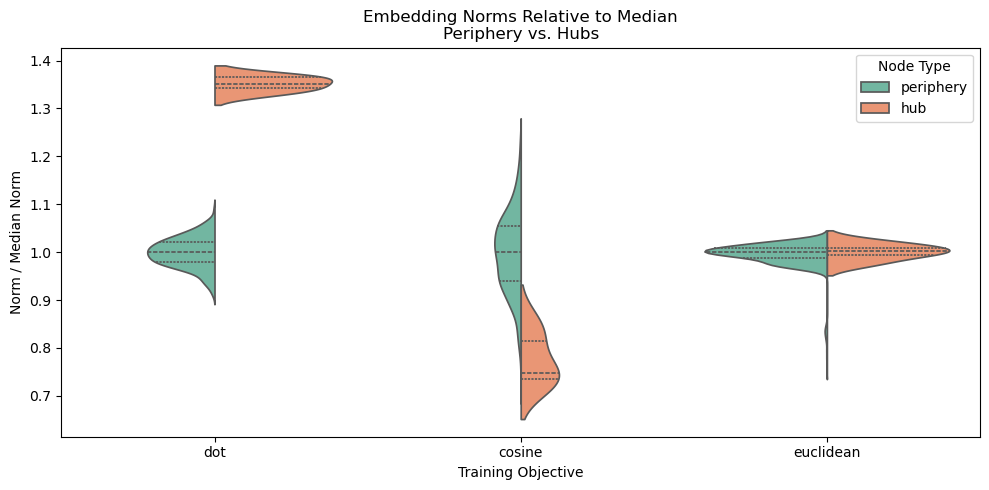

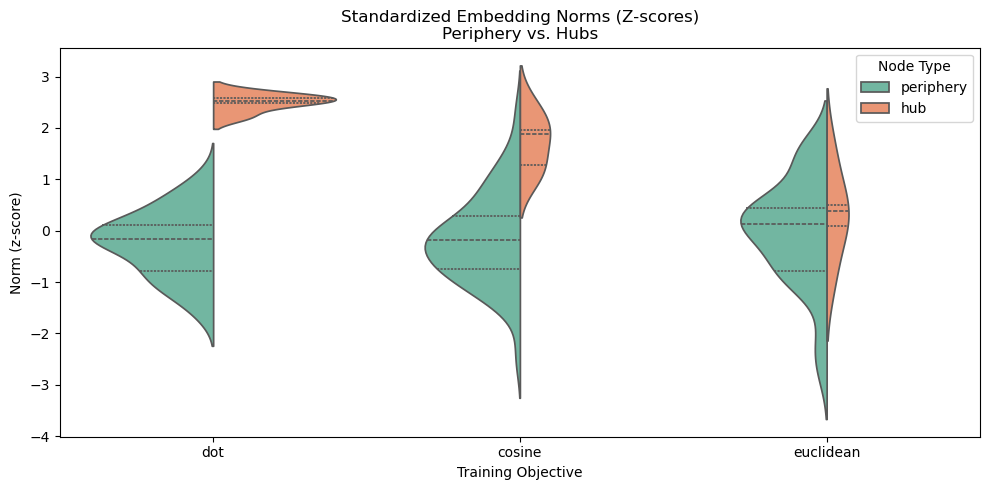

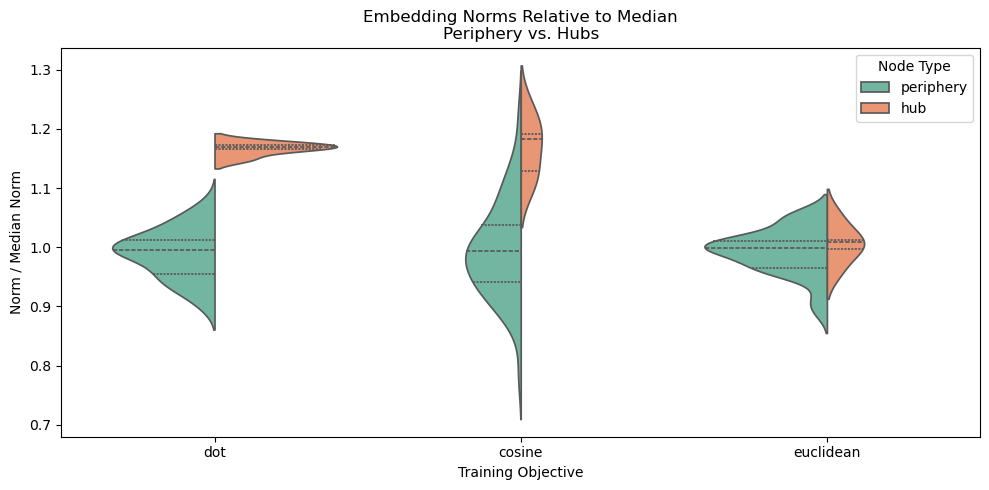